In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import U3Gate, ZZFeatureMap, ZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Gate, Parameter
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.optimizers import COBYLA, SPSA, L_BFGS_B
from pickle import load
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive

Mounted at /content/drive


In [ ]:
!pip install --upgrade qiskit==1.3.1 qiskit-machine-learning==0.8.2 pylatexenc qiskit_algorithms

In [ ]:
with open('dataset.obj',"rb") as f:
    dataset_loaded = load(f)
plt.imshow(dataset_loaded[0][0],cmap="gray")
print(dataset_loaded[0][1])

In [ ]:
data = np.array([x[0].flatten() for x in dataset_loaded])
labels = np.array([x[1] for x in dataset_loaded])
if data.dtype == bool:
    data = data.astype(np.float32)
data = (data - np.min(data)) / (np.max(data) - np.min(data))
print(len(data))

In [ ]:
for i in range(len(data)):
  if labels[i] == 0:
    labels[i] = -1
print(labels)

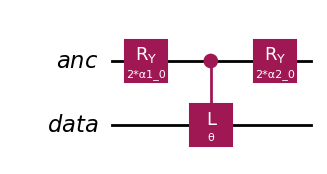

In [ ]:
# Residual block with two trainable rotations (index added to avoid param conflicts)
def residual_block_r2(l_gate: Gate, idx: int):
    anc = QuantumRegister(1, 'anc')
    data = QuantumRegister(1, 'data')
    qc = QuantumCircuit(anc, data, name="R2_block")

    alpha1 = Parameter(f"α1_{idx}")
    alpha2 = Parameter(f"α2_{idx}")

    qc.ry(2 * alpha1, anc[0])
    controlled_l = l_gate.control(1)
    qc.append(controlled_l, [anc[0], data[0]])
    qc.ry(2 * alpha2, anc[0])

    return qc, alpha1, alpha2


# Feature encoding using residual and Ry blocks
theta = Parameter("θ")
l_circuit = QuantumCircuit(1)
l_circuit.ry(theta, 0)
l_gate = l_circuit.to_gate(label="L")
qc, alpha, beta = residual_block_r2(l_gate, 0)
qc.draw("mpl")

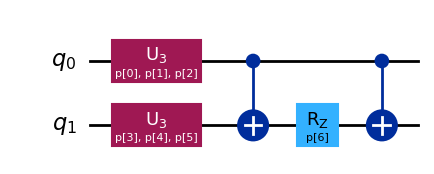

In [ ]:
# Define convolutional layer
def conv_layer(qubits, weight_params, idx):
    qc = QuantumCircuit(len(qubits), name="Convolution")

    for i, q in enumerate(qubits):
        theta, phi, lam = weight_params[idx], weight_params[idx + 1], weight_params[idx+2]
        idx += 3
        qc.append(U3Gate(theta, phi, lam), [q])
    for i in range(len(qubits) - 1):
        qc.cx(i, i+1)
        qc.rz(weight_params[idx], i+1)
        qc.cx(i, i+1)
    return qc


# qubits = list(range(2))
qubits = [0,1]
params = ParameterVector("p", 7)  # 4*3 (for U3) + 1 (for ZZ)
conv = conv_layer(qubits, params, 0)
conv.draw("mpl")

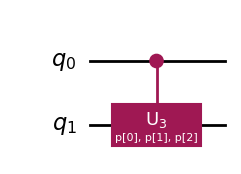

In [ ]:
# Define pooling layer
def pooling_layer(ctrl, tgt, params):
    qc = QuantumCircuit(2, name="Pooling")
    u3_gate = U3Gate(*params)
    cu3 = u3_gate.control(1)
    qc.append(cu3, [0, 1])
    return qc

pool_params = ParameterVector("p", 3)
pool_circ = pooling_layer(0, 1, pool_params)
pool_circ.draw("mpl")

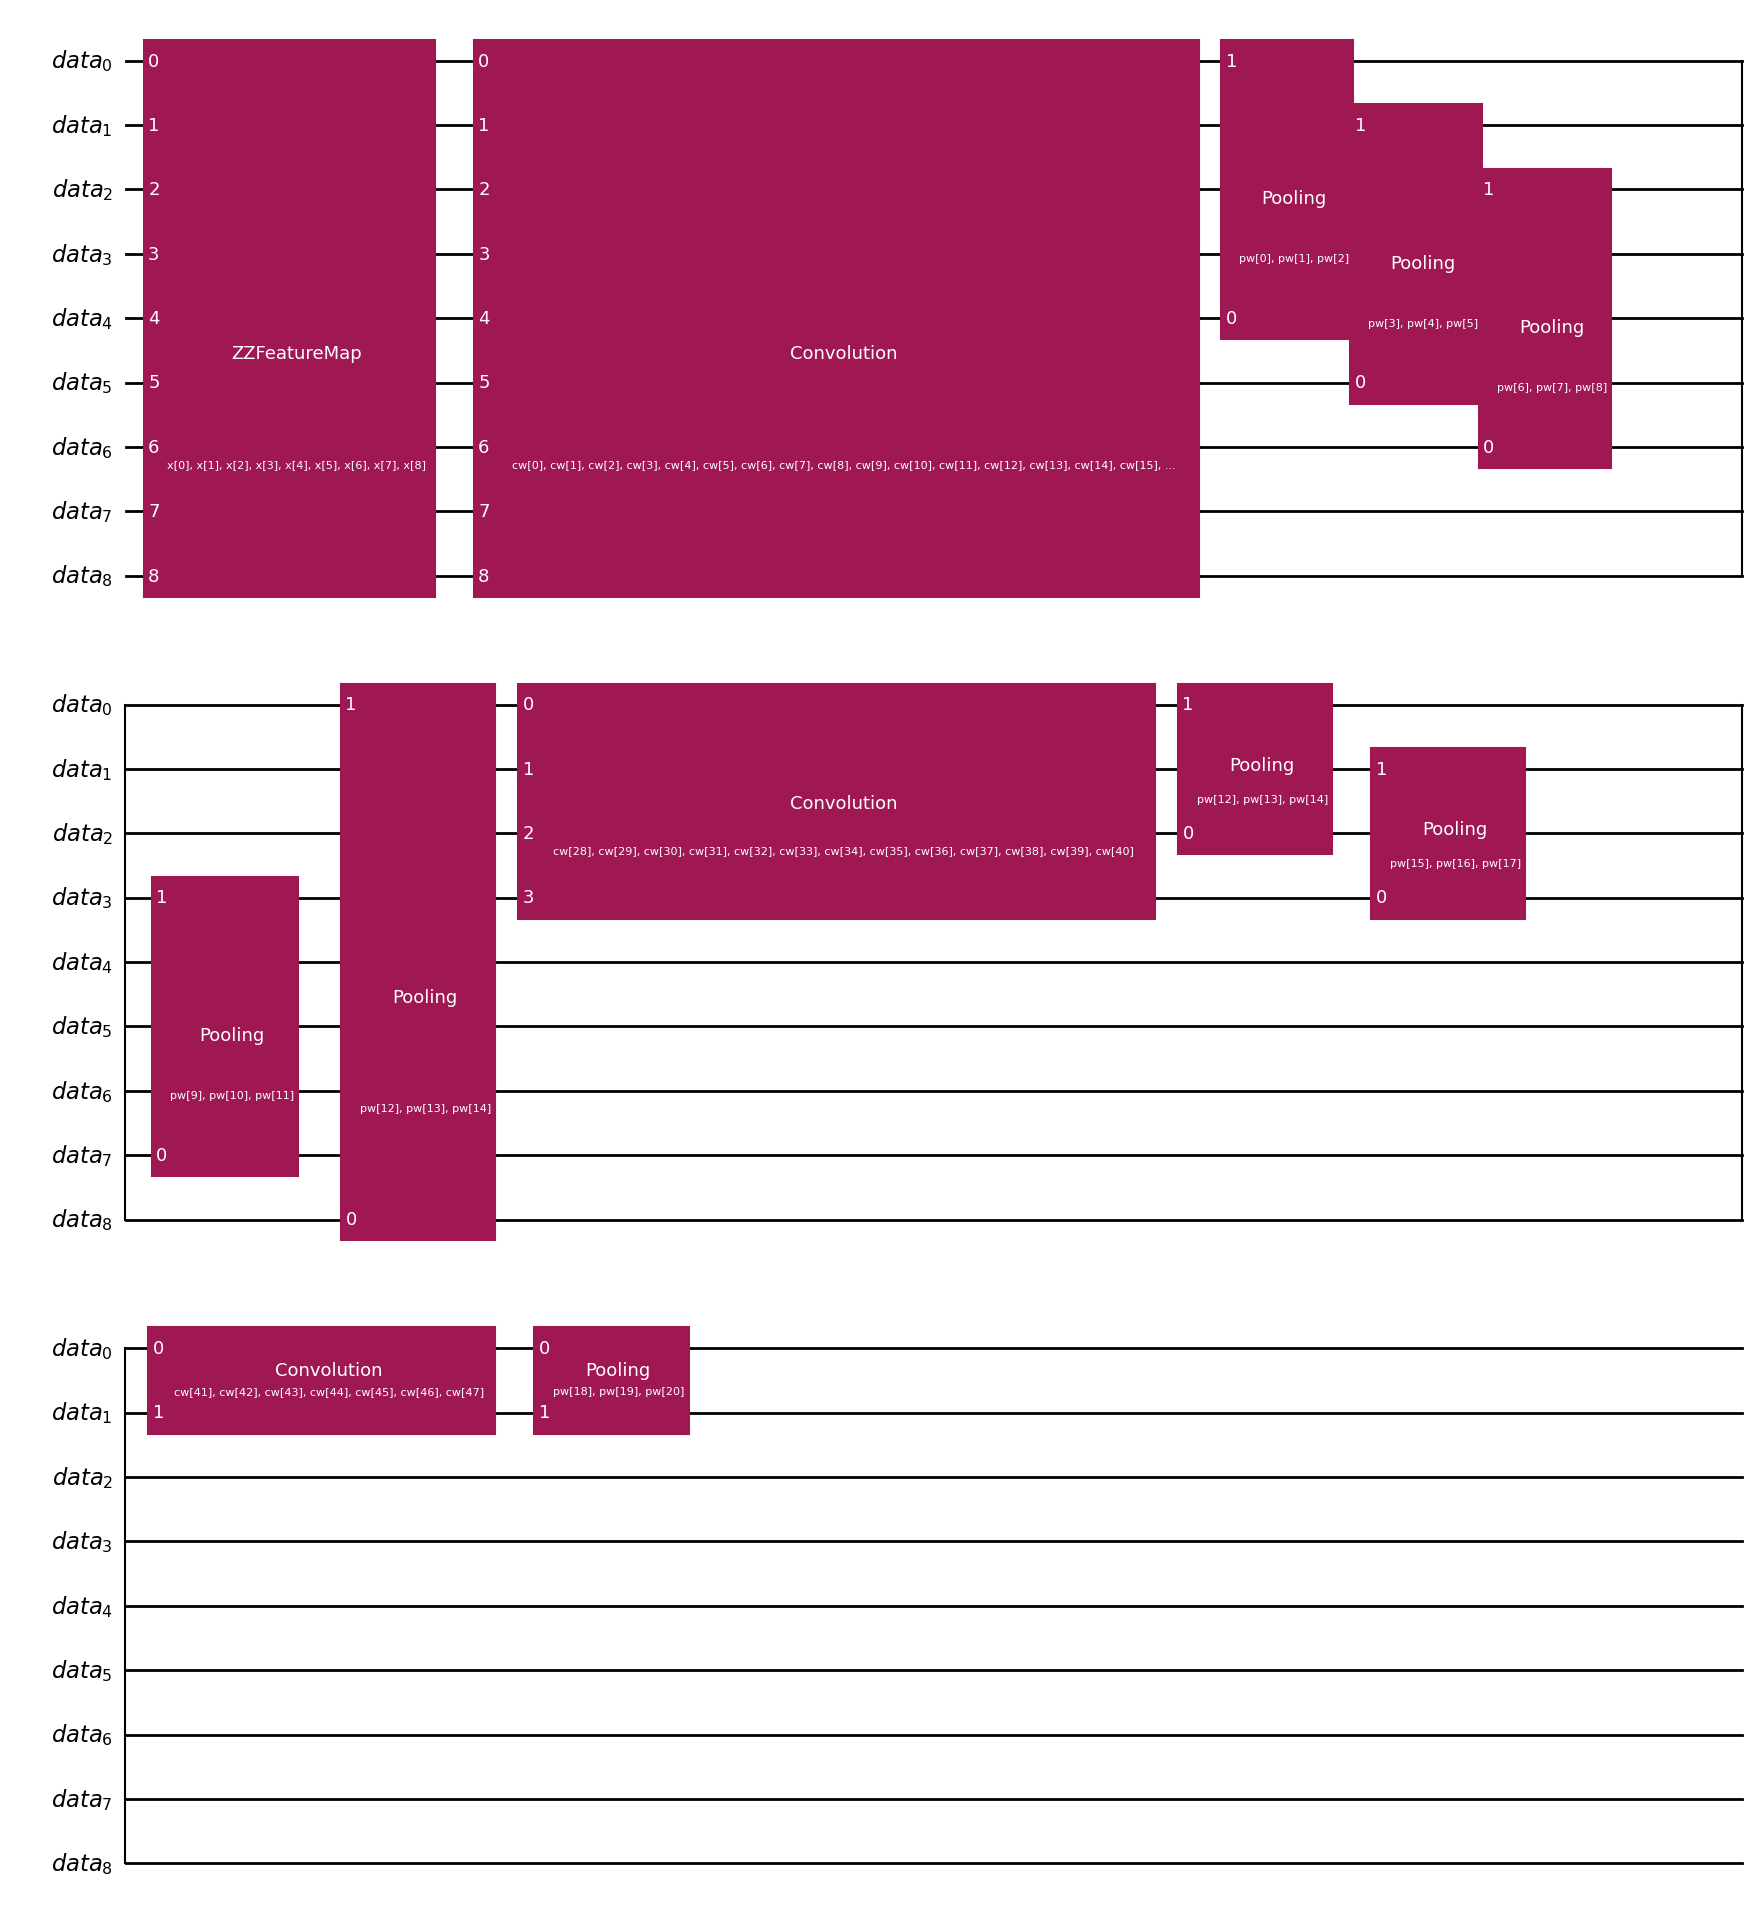

In [ ]:
# Build QCNN circuit
def build_qcnn():
    data = QuantumRegister(9, 'data')
    qc = QuantumCircuit(data)

    # ZZFeatureMap with parameters
    feature_map = ZZFeatureMap(feature_dimension=9, reps=2)
    input_params = feature_map.parameters
    qc.compose(feature_map, qubits=data[:], inplace=True)

    # Define trainable parameters
    conv_weights = ParameterVector('cw', 48)
    pool_weights = ParameterVector('pw', 21)  # 7 pooling layers, 3 params each = 21

    # Layer 1 - Convolution (9 qubits)
    conv1 = conv_layer(list(range(9)), conv_weights, 0)
    qc.append(conv1.to_instruction(), data[:])

    # Layer 2 - Pooling (9 -> 4)
    pool_pairs = [(4, 0), (5, 1), (6, 2), (7, 3), (8, 0)]
    for i, (ctrl, tgt) in enumerate(pool_pairs):
        idx = i * 3
        pool = pooling_layer(0, 1, pool_weights[idx:idx+3])
        qc.append(pool.to_instruction(), [data[ctrl], data[tgt]])

    # Layer 3 - Convolution (4 qubits)
    conv2 = conv_layer(list(range(4)), conv_weights, 28)
    qc.append(conv2.to_instruction(), data[0:4])

    # Layer 4 - Pooling (4 -> 2)
    pool2_pairs = [(2, 0), (3, 1)]
    for i, (ctrl, tgt) in enumerate(pool2_pairs):
        idx = 12 + i * 3
        pool = pooling_layer(0, 1, pool_weights[idx:idx+3])
        qc.append(pool.to_instruction(), [data[ctrl], data[tgt]])

    # Layer 5 - Convolution (2 qubits)
    conv3 = conv_layer(list(range(2)), conv_weights, 41)
    qc.append(conv3.to_instruction(), data[0:2])

    # Layer 6 - Pooling (2 -> 1)
    pool3 = pooling_layer(1, 0, pool_weights[18:21])
    qc.append(pool3.to_instruction(), [data[0], data[1]])

    return qc, input_params,  list(conv_weights) + list(pool_weights)

qcnn_circuit, input_params, weight_params = build_qcnn()
qcnn_circuit.draw("mpl")

In [ ]:
print((input_params))
print((weight_params))

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7]), ParameterVectorElement(x[8])])
[ParameterVectorElement(cw[0]), ParameterVectorElement(cw[1]), ParameterVectorElement(cw[2]), ParameterVectorElement(cw[3]), ParameterVectorElement(cw[4]), ParameterVectorElement(cw[5]), ParameterVectorElement(cw[6]), ParameterVectorElement(cw[7]), ParameterVectorElement(cw[8]), ParameterVectorElement(cw[9]), ParameterVectorElement(cw[10]), ParameterVectorElement(cw[11]), ParameterVectorElement(cw[12]), ParameterVectorElement(cw[13]), ParameterVectorElement(cw[14]), ParameterVectorElement(cw[15]), ParameterVectorElement(cw[16]), ParameterVectorElement(cw[17]), ParameterVectorElement(cw[18]), ParameterVectorElement(cw[19]), ParameterVectorElement(cw[20]), ParameterVectorElement(cw[21]), ParameterVectorElem

In [ ]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIII", 1),
])
estimator = StatevectorEstimator()
gradient = ParamShiftEstimatorGradient(estimator)

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
    gradient=gradient
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    initial_point=initial_point,
    loss="squared_error",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")

Loss: 1.0282
Loss: 1.0246
Loss: 1.0192
Loss: 1.0279
Loss: 1.0279
Loss: 1.0244
Loss: 1.0285
Loss: 1.0264
Loss: 1.0232
Loss: 1.0248
Loss: 1.0208
Loss: 1.0285
Loss: 1.0256
Loss: 1.0287
Loss: 1.0277
Loss: 1.0246
Loss: 1.0193
Loss: 1.0274
Loss: 1.0222
Loss: 1.0312
Loss: 1.0315
Loss: 1.0243
Loss: 1.0269
Loss: 1.0224
Loss: 1.0246
Loss: 0.9393
Loss: 0.9347
Loss: 0.9861
Loss: 0.9354
Loss: 0.9343
Loss: 0.9336
Loss: 0.9323
Loss: 0.9330
Loss: 0.9350
Loss: 0.9317
Loss: 0.9392
Loss: 0.9339
Loss: 0.9304
Loss: 0.9312
Loss: 0.9358
Loss: 0.9346
Loss: 0.9331
Loss: 0.9362
Loss: 0.9310
Loss: 0.9313
Loss: 0.9324
Loss: 0.9423
Loss: 0.9305
Loss: 0.9304
Loss: 0.9371
Loss: 0.9313
Loss: 0.9386
Loss: 0.9321
Loss: 0.9364
Loss: 0.9355
Loss: 0.9333
Loss: 0.9356
Loss: 0.9361
Loss: 0.9308
Loss: 0.9369
Loss: 0.9342
Loss: 0.9353
Loss: 0.9376
Loss: 0.9322
Loss: 0.9337
Loss: 0.9355
Loss: 0.9423
Loss: 0.9300
Loss: 0.9330
Loss: 0.9316
Loss: 0.9048
Loss: 0.9259
Loss: 0.9070
Loss: 0.9106
Loss: 0.9085
Loss: 0.9129
Loss: 0.9076

In [ ]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIII", 1),   # horizontal (top row start)
    ("ZZIIIIIII", 1),   # horizontal (top row start)
    ("IZZIIIIII", 1),   # horizontal (middle row start)
    ("IIIZZIIII", 1),   # horizontal (bottom row start)
    ("ZIZIIIIII", 1),   # vertical (1st col)
    ("IZIZIIIII", 1),   # vertical (2nd col)
    ("IIZIZIIII", 1),   # vertical (3rd col)
    ("ZIIIZIIII", 1),   # diagonal (\)
    ("IIZIZIZII", 1)    # anti-diagonal (/)
])
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),
    initial_point=initial_point,
    loss="squared_error",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")


Loss: 0.9664
Loss: 0.9711
Loss: 0.9676
Loss: 0.9684
Loss: 0.9669
Loss: 0.9643
Loss: 0.9726
Loss: 0.9688
Loss: 0.9689
Loss: 0.9682
Loss: 0.9679
Loss: 0.9724
Loss: 0.9658
Loss: 0.9667
Loss: 0.9684
Loss: 0.9697
Loss: 0.9741
Loss: 0.9689
Loss: 0.9704
Loss: 0.9646
Loss: 0.9678
Loss: 0.9702
Loss: 0.9743
Loss: 0.9695
Loss: 0.9670
Loss: 0.9379
Loss: 0.9421
Loss: 1.0284
Loss: 0.9406
Loss: 0.9342
Loss: 0.9395
Loss: 0.9399
Loss: 0.9396
Loss: 0.9346
Loss: 0.9440
Loss: 0.9351
Loss: 0.9352
Loss: 0.9422
Loss: 0.9351
Loss: 0.9396
Loss: 0.9423
Loss: 0.9350
Loss: 0.9381
Loss: 0.9402
Loss: 0.9407
Loss: 0.9378
Loss: 0.9419
Loss: 0.9349
Loss: 0.9400
Loss: 0.9395
Loss: 0.9434
Loss: 0.9407
Loss: 0.9428
Loss: 0.9374
Loss: 0.9349
Loss: 0.9392
Loss: 0.9372
Loss: 0.9380
Loss: 0.9352
Loss: 0.9442
Loss: 0.9471
Loss: 0.9343
Loss: 0.9355


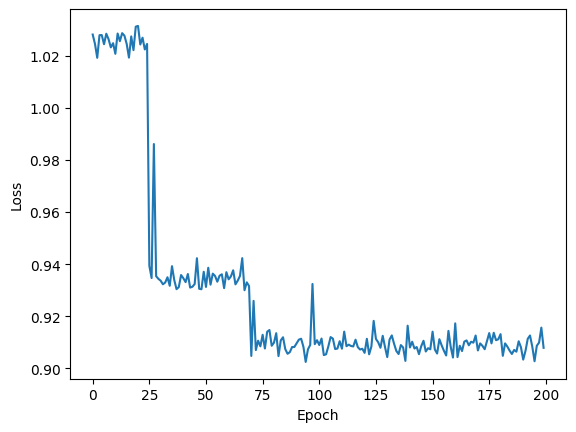

In [ ]:
plt.plot(loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
predictions = classifier.predict(data)
print(predictions)

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]


In [ ]:
cr = 0
for i in range(104):  # Show first 10 samples
    # print(f"Predicted: {predictions[i]}, Actual: {labels[i]}")
    if(predictions[i] == labels[i]):
      cr += 1
print(cr)

79


In [ ]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIII", 1),   # horizontal (top row start)
    ("ZZIIIIIII", 1),   # horizontal (top row start)
    ("IZZIIIIII", 1),   # horizontal (middle row start)
    ("IIIZZIIII", 1),   # horizontal (bottom row start)
    ("ZIZIIIIII", 1),   # vertical (1st col)
    ("IZIZIIIII", 1),   # vertical (2nd col)
    ("IIZIZIIII", 1),   # vertical (3rd col)
    ("ZIIIZIIII", 1),   # diagonal (\)
    ("IIZIZIZII", 1)    # anti-diagonal (/)
])
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=SPSA(maxiter=100),
    initial_point=initial_point,
    loss="cross_entropy",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")


Final Accuracy: 0.77


In [ ]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIII", 1),   # horizontal (top row start)
    ("ZZIIIIIII", 1),   # horizontal (top row start)
    ("IZZIIIIII", 1),   # horizontal (middle row start)
    ("IIIZZIIII", 1),   # horizontal (bottom row start)
    ("ZIZIIIIII", 1),   # vertical (1st col)
    ("IZIZIIIII", 1),   # vertical (2nd col)
    ("IIZIZIIII", 1),   # vertical (3rd col)
    ("ZIIIZIIII", 1),   # diagonal (\)
    ("IIZIZIZII", 1)    # anti-diagonal (/)
])
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=SPSA(maxiter=100),
    initial_point=initial_point,
    loss="squared_error",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")
